# Mountain Car


###  Code for Mountain Car 

We provide a `MountainCar` class that you can use. This implementation is based on the problem description given in [Example 8.2](http://www.incompleteideas.net/book/ebook/node89.html) of Sutton & Barto (1998) The following cells in this section will walk you through the basic usage of this class.

We import the mountaincar module and create a `MountainCar` object called `env`. The `reset()` method chooses a random starting `position` and starting `velocity` for the car, and sets the `game_over` variable to `False`. You can access these state variables independently using the same names.

In [1]:
import numpy as np
import mountaincar

np.random.seed(7)

env = mountaincar.MountainCar()
env.reset()
print("Starting position of the car", env.position)
print("Starting velocity of the car", env.velocity)
if not env.game_over:
    print("Game is not over yet.")

Starting position of the car -0.454704306550481
Starting velocity of the car 0.03128512489633177
Game is not over yet.


You can visualize the current position of the car using the `plot()` method.

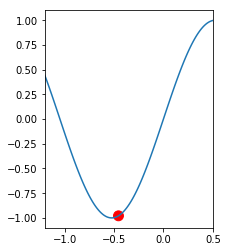

In [2]:
env.plot()

You can interact with the `MountainCar` environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. This method returns a `reward` signal, which is always -1.

The action can be one of the following integers:
* -1: full throttle reverse
*  0: zero throttle
*  1: full throttle forward

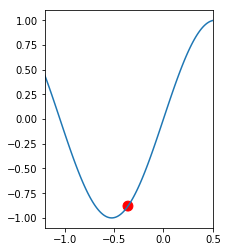

In [3]:
# Let's drive a bit full throttle forward and plot again.
env.make_step(action=1)
env.make_step(action=1)
env.make_step(action=1)
env.plot()

The following code snippet shows that even at full throttle the car cannot accelerate up the steep slope.

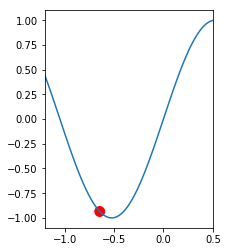

In [4]:
num_steps = 150
for episode in range(num_steps):
    # Always action 1 (full throttle forward)
    env.make_step(action=1)
    env.plot()

## Part 1: Linear Gradient Descent SARSA 


In [6]:
import matplotlib.pyplot as plt

class tile_coder:
    
    """The class defines the type of tiles used for the 
    Linear Gradient Descent SARSA. Using its flexible 
    settings we can change the number of tiles and tilings 
    along with their starting position.
    """
    
    def __init__(self, 
                 num_tiles = 9, 
                 num_tilings = 10, 
                 min_X = env.position_min, 
                 max_X = env.position_max, 
                 min_Y = env.velocity_min, 
                 max_Y = env.velocity_max):
        
        """The function is a constructor which initializes 
        the variables of a tile_coder object.
        
        ARGUMENTS
        ---------
        self: the tile_coder object
        num_tiles: number of tiles
        num_tilings: nuber of tilings
        min_X: minimum point on the environment grid on X axis
        max_X: maximum point on the environment grid on X axis
        min_Y: minimum point on the environment grid on Y axis
        min_Y: maximum point on the environment grid on Y axis
        
        """
        self.min_X = min_X
        self.max_X = max_X
        self.min_Y = min_Y
        self.max_Y = max_Y
        self.num_tiles = num_tiles
        self.num_tilings = num_tilings
        self.tile_width = (self.max_X - self.min_X) / (self.num_tiles - 1)       # Each tile is given equal space horizontally
        self.tile_height = (self.max_Y - self.min_Y) / (self.num_tiles - 1)      # and vertically
        self.offset_X = self.tile_width / (self.num_tiles - 1)                   # Offset from the previous tiling layer in X
        self.offset_Y = self.tile_height / (self.num_tiles - 1)                  # and Y axes
        
    def get_indice(self, position, velocity, action):
        
        """This function return the tile and tiling indicies for
        a Linear Gradient Descent SARSA agent for a given position,
        velocity and action.
        
        ARGUMENTS
        ---------
        self: the tile_coder object
        position: current position
        velocity: current velocity
        action: current action
        
        RETURNS
        -------
        indicies: array providing all the tile numbers (the index of 
        each value represents the tiling it belongs to).
        
        """
        indices = [0] * self.num_tilings                      # Initializes the indicies array with length as number of tilings 
        position -= self.min_X                                # Substract the starting position and velocity from current
        velocity -= self.min_Y                                # position and velocity
        for tiling in range(self.num_tilings):
            new_x = int(position / self.tile_width)           # Calculate the x and y co-ordinates
            new_y = int(velocity / self.tile_height)
            index = (new_y * self.num_tiles + new_x) + tiling * self.num_tiles * self.num_tiles   # index is the calculates as the linear position value
            index = index + action * tiling * self.num_tiles * self.num_tiles                     # incorporating tiling, tile number and action type
            indices[tiling] = index
            
            position += self.offset_X                         # new position and velocity at every tiling
            velocity += self.offset_Y
            
        return indices 

    
class Linear_GD_Sarsa_Agent:
    
    """This class defines a Linear GD SARSA agent.
    """
    
    def __init__(self, alpha = 0.01, greedy = 0.1, gamma = 1, lambada = 0.9):
        
        """This is a constructor which initializes 
        the class' object variables.
        
        ARGUMENTS
        ---------
        self: the Linear_GD_Sarsa_Agent object 
        alpha
        greedy: epsilon greedy 
        gamma
        lambda
        theta: size defined as number of tiling * (number of tiles)^2 * number of actions
        
        """
        self.alpha = alpha
        self.greedy = greedy
        self.gamma = gamma
        self.lambada = lambada
        self.theta = np.zeros(2430)
        
    def choose_action(self, tile, env):
        
        """This function returns the action and its 
        corresponding q_value when called.
        
        ARGUMENTS
        ---------
        self: the Linear_GD_Sarsa_Agent object 
        tile: tile_coder object
        env: the mountain_car environment
        
        RETURNS
        -------
        chosen_action
        q_value: for the chosen action
        
        """
        q_value = 0
        chosen_action = 0

        if np.random.rand(1) >= self.greedy: 
            # choose greedy action
            q = {}
            for action in env.actions:                             # check q values for each action
                features_vector = tile.get_indice(env.position, env.velocity, action) # extract indices for the particular position and velocity
                q[action] = self.theta[features_vector].sum()      # q value calculated as the sum of all theta values for the feature vector  
            max_q = np.array([q[key] for key in q.keys()]).max()   
            chosen_action = np.random.choice([key for key in q.keys() if q[key]==max_q])  # action with the maximum q value is chosen 
            q_value = q[chosen_action]
        else:
            # choose not greedy action
            chosen_action = np.random.choice(env.actions)          # action is chosen at random
            features_vector = tile.get_indice(env.position, env.velocity, chosen_action)
            q_value = self.theta[features_vector].sum() 


        return chosen_action, q_value
        

def simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'accumulating'):
    
    """This function simulates the Linear GD Sarsa agent in the mountaincar environment.
    
    ARGUMENTS
    ---------
    agent: the Linear_GD_Sarsa_Agent object
    env: the mountaincar object
    episodes: number of episodes
    trace_type: the eligibility tracing type can be accumulating or replacing 
    
    RETURNS
    -------
    reward_ret: reward for each step
    all_steps: number of steps in each episode
    
    """
    reward_ret = np.zeros(episodes)
    
    all_steps = []
    
    for episode in range(1, episodes+1):
        total_reward = 0
        env.reset()                      # reset the enviornment at the begining of each episode
        e = np.zeros(agent.theta.shape)  # eligibility trace has the same shape as theta
        
        step_counter = 0
        
        # choose the initial action randomly
        current_action = agent.choose_action(tile, env)[0]      # choose the best action or a random action and return with its q_value
        features_vector = tile.get_indice(env.position, env.velocity, current_action)    # get all tile indices for the position, velocity and action
        # for each step, learn
        while env.game_over == False:
            if trace_type == 'accumulating':   #accumulating trace
                e[features_vector] += 1
            elif trace_type == 'replacing':    #replacing trace
                e[features_vector] = 1
            else:
                raise ValueError("The tracing type %s should be either 'accumulating' or 'replacing'" \
                                 % trace_type)
                
            reward = env.make_step(current_action)  # changes the position on grid and calculate reward
            total_reward += reward
            delta = reward - agent.theta[features_vector].sum()       # delta value 
            next_action, q_value = agent.choose_action(tile, env)     # choose the best action or a random action and return with its q_value
            delta = delta + agent.gamma * q_value                     
            agent.theta = agent.theta + agent.alpha * delta * e       # update delta value
            e = agent.gamma * agent.lambada * e                       # update e
            # update for next step
            current_action = next_action                              # update action
            features_vector = tile.get_indice(env.position, env.velocity, current_action) # get indices for the new action 
            step_counter += 1
        
        reward_ret[episode-1] = total_reward      
        all_steps.append(step_counter)
        
    return reward_ret, all_steps


### Average Return per Episode Learning Curve

#### 1 Agent - 10000 Episodes

In [7]:

num_tiles = 9
num_tilings = 10

tile = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
agent_1 = Linear_GD_Sarsa_Agent(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
env = mountaincar.MountainCar()
episodes = 10000
ret, steps = simulate_Linear_GD_Sarsa(agent_1, env, episodes, trace_type = 'replacing')




In [8]:
all_avg_ret = []
sum_ret = 0
batch =1000
iteration = []

# Averaging reward over a batch of 1000 episodes
for i in range(1,len(ret)):
    if i%batch == 0:
        avg_ret = sum_ret/batch
        all_avg_ret.append(avg_ret)
        iteration.append(i)
        sum_ret = 0
    else:
        sum_ret += ret[i]

# Plotting the learning curve        
plt.figure(figsize=(10,8))
plt.plot(iteration, all_avg_ret, 'k', label='1 Agent')
plt.plot(iteration[-1], all_avg_ret[-1], 'k.', markersize=10, label='r = %.2f' %all_avg_ret[-1])
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title('Learning Curve for 1 Linear Gradient Descent SARSA agent')
plt.legend(loc='best')
plt.show()

#### 5 Agents - 10000 Episodes

In [9]:
# initial parameters
num_tiles = 9
num_tilings = 10

tile = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
episodes = 10000

agent_rets = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'accumulating')
    agent_rets.append(ret)


In [10]:
comb_avg_ret = []
batch =1000
iteration = np.linspace(0, 8, 9)*batch

# Averaging reward over a batch of 1000 episodes for 5 agents
for k in range(0,5):
    all_avg_ret = []
    sum_ret = 0
    for i in range(1,len(agent_rets[k])):
        if i%batch == 0:
            avg_ret = sum_ret/batch
            all_avg_ret.append(avg_ret)
#             iteration.append(i)
            sum_ret = 0
        else:
            sum_ret += ret[i]
    comb_avg_ret.append(all_avg_ret)        

  
plt.figure(figsize=(10,8))
plt.plot(iteration,np.array(comb_avg_ret).mean(axis = 0), 'k', label='5 Agents')
plt.plot(iteration[-1],np.array(comb_avg_ret).mean(axis = 0)[-1], 'k.', label='r = %.2f' %np.array(comb_avg_ret).mean(axis = 0)[-1], markersize=10)
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title('Learning Curve for 5 Linear Gradient Descent SARSA agent')
plt.legend(loc='lower right')
plt.show()


### Steps per Episode Learning Curve

#### 1 Agent - 5000 Episodes

In [11]:
num_tiles = 9
num_tilings = 10

tile = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
agent_1 = Linear_GD_Sarsa_Agent(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
env = mountaincar.MountainCar()
episodes = 5000
ret, steps = simulate_Linear_GD_Sarsa(agent_1, env, episodes, trace_type = 'replacing')


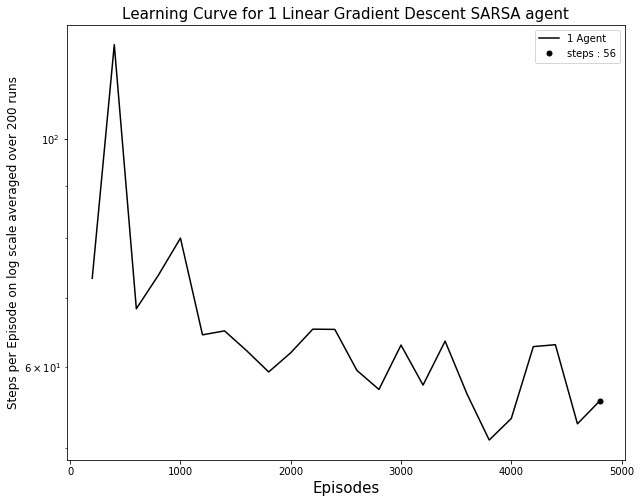

In [12]:
all_avg_steps = []
sum_steps = 0
batch =200
iteration = []

# Averaging reward over a batch of 200 episodes
for i in range(1,len(ret)):
    if i%batch == 0:
        avg_steps = sum_steps/batch
        all_avg_steps.append(avg_steps)
        iteration.append(i)
        sum_steps = 0
    else:
        sum_steps += steps[i]

# Plotting the learning curve         
plt.figure(figsize=(10,8))
plt.plot(iteration, all_avg_steps, 'k', label='1 Agent')
plt.plot(iteration[-1], all_avg_steps[-1], 'k.', markersize=10, label='steps : %.0f' %all_avg_steps[-1])
plt.yscale('log')
plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Steps per Episode on log scale averaged over 200 runs', fontsize=12)
plt.title('Learning Curve for 1 Linear Gradient Descent SARSA agent', fontsize=15)
plt.legend(loc='best')
plt.show()

#### 5 Agents (Each Accumulating and Replacing Trace) - 5000 Episodes 

In [13]:
num_tiles = 9
num_tilings = 10

tile = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
episodes = 5000

agent_steps_rep = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_rep.append(steps)
    
agent_steps_acc = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'accumulating')
    agent_steps_acc.append(steps)    

In [14]:
comb_avg_steps_rep = []
comb_avg_steps_acc = []
batch =500
iteration = np.linspace(0, 8, 9)*batch

# Averaging reward over a batch of 1000 episodes for 5 agents for accumulating and replacing traces
for k in range(0,5):
    all_avg_steps_rep = []
    all_avg_steps_acc = []
    sum_rep = 0
    sum_acc = 0
    for i in range(1,len(agent_steps_rep[k])):
        if i%batch == 0:
            avg_rep = sum_rep/batch
            avg_acc = sum_acc/batch
            
            all_avg_steps_rep.append(avg_rep)
            all_avg_steps_acc.append(avg_acc)

            sum_rep = 0
            sum_acc = 0
        else:
            sum_rep += agent_steps_rep[k][i]
            sum_acc += agent_steps_acc[k][i]
            
    comb_avg_steps_rep.append(all_avg_steps_rep) 
    comb_avg_steps_acc.append(all_avg_steps_acc)

    
plt.figure(figsize=(10,8))

plt.plot(iteration, np.array(comb_avg_steps_rep).mean(axis = 0), 'k', label='5 Agents Replacing Trace')
plt.plot(iteration[-1], np.array(comb_avg_steps_rep).mean(axis = 0)[-1], 'k.', label='Steps : %.0f' %np.array(comb_avg_steps_rep).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_acc).mean(axis = 0), 'r', label='5 Agents Accumulating Trace')
plt.plot(iteration[-1], np.array(comb_avg_steps_acc).mean(axis = 0)[-1], 'r.', label='Steps : %.0f' %np.array(comb_avg_steps_acc).mean(axis = 0)[-1], markersize=10)

plt.yscale('log')
plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Steps per Episode on log scale averaged over 500 runs', fontsize=12)
plt.title('Learning Curve for 5 Linear Gradient Descent SARSA agent', fontsize=15)
plt.legend(loc='best')
plt.show()


<img src="LC_avg_return.png" style="width: 500px;"/>
<img src="LC_steps_per_episode.png" style="width: 500px;"/> 

The figure A and B above shows the average return and average steps per episode learning curve of a Linear GD SARSA agent trained for 10000 and 5000 episodes respectively. It represents the return increasing (decreasing in absolute value) with training which indicates that the agent takes lesser and lesser steps to solve the problem. The results become more evident from the steps per episode learning curve as it shows that with increasing training episodes the number of steps required reduces that is the agent optimizes its policy to reach the hill top as soon as possible. 

The choice of parameter settings are as follows α = 0.1/tilings, ε = 0.01 γ = 1 and λ = 0.1. The exploration parameter ε has been set to minimum in order to achieve maximum reward in the smallest number of episodes. The γ value is set to 1 so that the current state can have the maximum effect on the TD error. The λ value determines the influence of previous states on the q value, it is set to low so that the influence is predominantely from the current state.

The figure also shows a comparison between accumulating and replacing traces. We observe that the accumulating trace learns smoother than replacing trace and performs better (the final steps being 56 for accumulating trace and 59 for replacing trace). 

## Part 2 


### Changes in Hyperparameters : Alpha, Tiles, Tilings

#### Different alpha values: 0.01, 0.02 and 0.05

In [16]:
num_tiles = 9
num_tilings = 10

tile = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
episodes = 4000

agent_steps_pt1 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_pt1.append(steps)
    
agent_steps_pt2 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent(alpha = 0.2/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'accumulating')
    agent_steps_pt2.append(steps)  
    
agent_steps_pt5 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent(alpha = 0.5/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'accumulating')
    agent_steps_pt5.append(steps)     

In [17]:
comb_avg_steps_pt1 = []
comb_avg_steps_pt2 = []
comb_avg_steps_pt5 = []
batch =400
iteration = np.linspace(0, 8, 9)*batch

for k in range(0,5):
    all_avg_steps_pt1 = []
    all_avg_steps_pt2 = []
    all_avg_steps_pt5 = []
    sum_pt1 = 0
    sum_pt2 = 0
    sum_pt5 = 0
    for i in range(1,len(agent_steps_pt1[k])):
        if i%batch == 0:
            avg_pt1 = sum_pt1/batch
            avg_pt2 = sum_pt2/batch
            avg_pt5 = sum_pt5/batch
            
            all_avg_steps_pt1.append(avg_pt1)
            all_avg_steps_pt2.append(avg_pt2)
            all_avg_steps_pt5.append(avg_pt5)

            sum_pt1 = 0
            sum_pt2 = 0
            sum_pt5 = 0
        else:
            sum_pt1 += agent_steps_pt1[k][i]
            sum_pt2 += agent_steps_pt2[k][i]
            sum_pt5 += agent_steps_pt5[k][i]
            
    comb_avg_steps_pt1.append(all_avg_steps_pt1) 
    comb_avg_steps_pt2.append(all_avg_steps_pt2)
    comb_avg_steps_pt5.append(all_avg_steps_pt5)

    
plt.figure(figsize=(10,8))

plt.plot(iteration, np.array(comb_avg_steps_pt1).mean(axis = 0), 'b', label='5 Agents w/ α = 0.01')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt1).mean(axis = 0)[-1], 'b.', label='Steps : %.0f' %np.array(comb_avg_steps_pt1).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_pt2).mean(axis = 0), 'g', label='5 Agents w/ α = 0.02')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt2).mean(axis = 0)[-1], 'g.', label='Steps : %.0f' %np.array(comb_avg_steps_pt2).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_pt5).mean(axis = 0), 'r', label='5 Agents w/ α = 0.05')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt5).mean(axis = 0)[-1], 'r.', label='Steps : %.0f' %np.array(comb_avg_steps_pt5).mean(axis = 0)[-1], markersize=10)

plt.yscale('log')
plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Steps per Episode on log scale averaged over 400 runs', fontsize=12)
plt.title('Learning Curve for 3 Linear Gradient Descent SARSA agents with different α values', fontsize=12)
plt.legend(loc='best')
plt.show()


#### Different number of tiles: 5, 10, 15, 20

In [18]:
import matplotlib.pyplot as plt

class tile_coder:
    def __init__(self, 
                 num_tiles = 9, 
                 num_tilings = 10, 
                 min_X = env.position_min, 
                 max_X = env.position_max, 
                 min_Y = env.velocity_min, 
                 max_Y = env.velocity_max):
        self.min_X = min_X
        self.max_X = max_X
        self.min_Y = min_Y
        self.max_Y = max_Y
        self.num_tiles = num_tiles
        self.num_tilings = num_tilings
        self.tile_width = (self.max_X - self.min_X) / (self.num_tiles - 1)
        self.tile_height = (self.max_Y - self.min_Y) / (self.num_tiles - 1)
        self.offset_X = self.tile_width / (self.num_tiles - 1)
        self.offset_Y = self.tile_height / (self.num_tiles - 1)
        
    def get_indice(self, position, velocity, action):
        indices = [0] * self.num_tilings
        position -= self.min_X
        velocity -= self.min_Y
        for tiling in range(self.num_tilings):
            new_x = int(position / self.tile_width)
            new_y = int(velocity / self.tile_height)
            index = (new_y * self.num_tiles + new_x) + tiling * self.num_tiles * self.num_tiles
            index = index + action * tiling * self.num_tiles * self.num_tiles
            indices[tiling] = index
            
            position += self.offset_X
            velocity += self.offset_Y
            
        return indices 

    
class Linear_GD_Sarsa_Agent_2:
    def __init__(self, alpha = 0.01, greedy = 0.1, gamma = 1, lambada = 0.9, theta_size = 2430):
        self.alpha = alpha
        self.greedy = greedy
        self.gamma = gamma
        self.lambada = lambada
        self.theta = np.zeros(theta_size)
        
    def choose_action(self, tile, env):
        # enable_greedy = False is used for test only, never make the non-greedy move
        # default as True, have a probability to make the non-greedy move
        q_value = 0
        chosen_action = 0

        if np.random.rand(1) >= self.greedy:
            # choose greedy action
            q = {}
            for action in env.actions:
                features_vector = tile.get_indice(env.position, env.velocity, action)
                q[action] = self.theta[features_vector].sum()
            max_q = np.array([q[key] for key in q.keys()]).max()
            chosen_action = np.random.choice([key for key in q.keys() if q[key]==max_q])
            q_value = q[chosen_action]
        else:
            # choose not greedy action
            chosen_action = np.random.choice(env.actions)
            features_vector = tile.get_indice(env.position, env.velocity, chosen_action)
            q_value = self.theta[features_vector].sum() 


        return chosen_action, q_value
        

def simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'accumulating'):
    # trace_type means the eligibility tracing type, either accumulating or replacing
    # default as accumulating
    reward_ret = np.zeros(episodes)
    
    all_steps = []
    
    for episode in range(1, episodes+1):
        total_reward = 0
        env.reset()
        e = np.zeros(agent.theta.shape)
        
        step_counter = 0
        
        # choose the initial action randomly
        current_action = agent.choose_action(tile, env)[0]
        features_vector = tile.get_indice(env.position, env.velocity, current_action)
        # for each step, learn
        while env.game_over == False:
            if trace_type == 'accumulating':   #accumulating trace
                e[features_vector] += 1
            elif trace_type == 'replacing':   #replacing trace
                e[features_vector] = 1
            else:
                raise ValueError("The tracing type %s should be either 'accumulating' or 'replacing'" \
                                 % trace_type)
                
            reward = env.make_step(current_action)
            total_reward += reward
            delta = reward - agent.theta[features_vector].sum()
            next_action, q_value = agent.choose_action(tile, env)
            delta = delta + agent.gamma * q_value
            agent.theta = agent.theta + agent.alpha * delta * e
            e = agent.gamma * agent.lambada * e
            # update for next step
            current_action = next_action
            features_vector = tile.get_indice(env.position, env.velocity, current_action)
            step_counter += 1
        
        reward_ret[episode-1] = total_reward
        all_steps.append(step_counter)
        
    return reward_ret, all_steps


In [19]:
num_tilings = 10
episodes = 4000

num_tiles = 10
tile10 = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
agent_steps_pt1 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent_2(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1, theta_size = 3000)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_pt1.append(steps)

num_tiles = 20
tile20 = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
agent_steps_pt2 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent_2(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1, theta_size = 12000)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_pt2.append(steps)  
    
    

In [20]:
num_tiles = 5
tile5 = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
agent_steps_pt5 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent_2(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1, theta_size = 3000)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_pt5.append(steps) 

In [21]:
num_tiles = 15
tile15 = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
agent_steps_pt15 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent_2(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1, theta_size = 6750)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_pt15.append(steps) 

In [22]:
comb_avg_steps_pt1 = []
comb_avg_steps_pt2 = []
comb_avg_steps_pt5 = []
comb_avg_steps_pt15 = []
batch =400
iteration = np.linspace(0, 8, 9)*batch

for k in range(0,5):
    all_avg_steps_pt1 = []
    all_avg_steps_pt2 = []
    all_avg_steps_pt5 = []
    all_avg_steps_pt15 = []
    sum_pt1 = 0
    sum_pt2 = 0
    sum_pt5 = 0
    sum_pt15 = 0
    for i in range(1,len(agent_steps_pt1[k])):
        if i%batch == 0:
            avg_pt1 = sum_pt1/batch
            avg_pt2 = sum_pt2/batch
            avg_pt5 = sum_pt5/batch
            avg_pt15 = sum_pt15/batch
            
            all_avg_steps_pt1.append(avg_pt1)
            all_avg_steps_pt2.append(avg_pt2)
            all_avg_steps_pt5.append(avg_pt5)
            all_avg_steps_pt15.append(avg_pt15)

            sum_pt1 = 0
            sum_pt2 = 0
            sum_pt5 = 0
            sum_pt15 = 0
        else:
            sum_pt1 += agent_steps_pt1[k][i]
            sum_pt2 += agent_steps_pt2[k][i]
            sum_pt5 += agent_steps_pt5[k][i]
            sum_pt15 += agent_steps_pt15[k][i]
            
    comb_avg_steps_pt1.append(all_avg_steps_pt1) 
    comb_avg_steps_pt2.append(all_avg_steps_pt2)
    comb_avg_steps_pt5.append(all_avg_steps_pt5)
    comb_avg_steps_pt15.append(all_avg_steps_pt15)

    
plt.figure(figsize=(10,8))

plt.plot(iteration, np.array(comb_avg_steps_pt1).mean(axis = 0), 'b', label='5 Agents w/ tile = 10')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt1).mean(axis = 0)[-1], 'b.', label='Steps : %.0f' %np.array(comb_avg_steps_pt1).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_pt2).mean(axis = 0), 'g', label='5 Agents w/ tile = 20')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt2).mean(axis = 0)[-1], 'g.', label='Steps : %.0f' %np.array(comb_avg_steps_pt2).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_pt5).mean(axis = 0), 'r', label='5 Agents w/ tile = 5')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt5).mean(axis = 0)[-1], 'r.', label='Steps : %.0f' %np.array(comb_avg_steps_pt5).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_pt15).mean(axis = 0), 'y', label='5 Agents w/ tile = 15')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt15).mean(axis = 0)[-1], 'y.', label='Steps : %.0f' %np.array(comb_avg_steps_pt15).mean(axis = 0)[-1], markersize=10)

plt.yscale('log')
plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Steps per Episode on log scale averaged over 400 runs', fontsize=12)
plt.title('Learning Curve for 3 Linear Gradient Descent SARSA agent with different number of tiles', fontsize=12)
plt.legend(loc='best')
plt.show()


#### Different number of tilings: 5, 10, 15, 20

In [23]:
num_tiles = 9


episodes = 4000

num_tilings = 10
tile10 = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
agent_steps_pt1 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent_2(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1, theta_size = 3000)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_pt1.append(steps)
        
    

In [24]:
num_tilings = 20
tile20 = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
agent_steps_pt2 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent_2(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1, theta_size = 4860)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_pt2.append(steps)  
    


In [25]:
num_tilings = 5
tile5 = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
agent_steps_pt5 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent_2(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1, theta_size = 3000)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_pt5.append(steps)     
    


In [26]:
num_tilings = 15
tile15 = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
agent_steps_pt15 = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent_2(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1, theta_size = 3645)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'replacing')
    agent_steps_pt15.append(steps) 

In [27]:
comb_avg_steps_pt1 = []
comb_avg_steps_pt2 = []
comb_avg_steps_pt5 = []
comb_avg_steps_pt15 = []
batch =400
iteration = np.linspace(0, 8, 9)*batch

for k in range(0,5):
    all_avg_steps_pt1 = []
    all_avg_steps_pt2 = []
    all_avg_steps_pt5 = []
    all_avg_steps_pt15 = []
    sum_pt1 = 0
    sum_pt2 = 0
    sum_pt5 = 0
    sum_pt15 = 0
    for i in range(1,len(agent_steps_pt1[k])):
        if i%batch == 0:
            avg_pt1 = sum_pt1/batch
            avg_pt2 = sum_pt2/batch
            avg_pt5 = sum_pt5/batch
            avg_pt15 = sum_pt15/batch
            
            all_avg_steps_pt1.append(avg_pt1)
            all_avg_steps_pt2.append(avg_pt2)
            all_avg_steps_pt5.append(avg_pt5)
            all_avg_steps_pt15.append(avg_pt15)

            sum_pt1 = 0
            sum_pt2 = 0
            sum_pt5 = 0
            sum_pt15 = 0
        else:
            sum_pt1 += agent_steps_pt1[k][i]
            sum_pt2 += agent_steps_pt2[k][i]
            sum_pt5 += agent_steps_pt5[k][i]
            sum_pt15 += agent_steps_pt15[k][i]
            
    comb_avg_steps_pt1.append(all_avg_steps_pt1) 
    comb_avg_steps_pt2.append(all_avg_steps_pt2)
    comb_avg_steps_pt5.append(all_avg_steps_pt5)
    comb_avg_steps_pt15.append(all_avg_steps_pt15)

    
plt.figure(figsize=(10,8))

plt.plot(iteration, np.array(comb_avg_steps_pt1).mean(axis = 0), 'b', label='5 Agents w/ tiling = 10')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt1).mean(axis = 0)[-1], 'b.', label='Steps : %.0f' %np.array(comb_avg_steps_pt1).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_pt2).mean(axis = 0), 'g', label='5 Agents w/ tiling = 20')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt2).mean(axis = 0)[-1], 'g.', label='Steps : %.0f' %np.array(comb_avg_steps_pt2).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_pt5).mean(axis = 0), 'r', label='5 Agents w/ tiling = 5')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt5).mean(axis = 0)[-1], 'r.', label='Steps : %.0f' %np.array(comb_avg_steps_pt5).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_pt15).mean(axis = 0), 'y', label='5 Agents w/ tiling = 15')
plt.plot(iteration[-1], np.array(comb_avg_steps_pt15).mean(axis = 0)[-1], 'y.', label='Steps : %.0f' %np.array(comb_avg_steps_pt15).mean(axis = 0)[-1], markersize=10)

plt.yscale('log')
plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Steps per Episode on log scale averaged over 400 runs', fontsize=12)
plt.title('Learning Curve for 4 Linear Gradient Descent SARSA agent with different number of tilings', fontsize=12)
plt.legend(loc='best')
plt.show()


### New Algorithm: Linear Gradient Descent Q(λ)

In [28]:
import matplotlib.pyplot as plt

class tile_coder:
    
    """The class defines the type of tiles used for the 
    Linear Gradient Descent Q. Using its flexible 
    settings we can change the number of tiles and tilings 
    along with their starting position.
    """
    
    def __init__(self, 
                 num_tiles = 9, 
                 num_tilings = 10, 
                 min_X = env.position_min, 
                 max_X = env.position_max, 
                 min_Y = env.velocity_min, 
                 max_Y = env.velocity_max):
        
        """The function is a constructor which initializes 
        the variables of a tile_coder object.
        
        ARGUMENTS
        ---------
        self: the tile_coder object
        num_tiles: number of tiles
        num_tilings: nuber of tilings
        min_X: minimum point on the environment grid on X axis
        max_X: maximum point on the environment grid on X axis
        min_Y: minimum point on the environment grid on Y axis
        min_Y: maximum point on the environment grid on Y axis
        
        """
        self.min_X = min_X
        self.max_X = max_X
        self.min_Y = min_Y
        self.max_Y = max_Y
        self.num_tiles = num_tiles
        self.num_tilings = num_tilings
        self.tile_width = (self.max_X - self.min_X) / (self.num_tiles - 1)       # Each tile is given equal space horizontally
        self.tile_height = (self.max_Y - self.min_Y) / (self.num_tiles - 1)      # and vertically
        self.offset_X = self.tile_width / (self.num_tiles - 1)                   # Offset from the previous tiling layer in X
        self.offset_Y = self.tile_height / (self.num_tiles - 1)                  # and Y axes
        
    def get_indice(self, position, velocity, action):
        
        """This function return the tile and tiling indicies for
        a Linear Gradient Descent Q agent for a given position,
        velocity and action.
        
        ARGUMENTS
        ---------
        self: the tile_coder object
        position: current position
        velocity: current velocity
        action: current action
        
        RETURNS
        -------
        indicies: array providing all the tile numbers (the index of 
        each value represents the tiling it belongs to).
        
        """
        indices = [0] * self.num_tilings                      # Initializes the indicies array with length as number of tilings 
        position -= self.min_X                                # Substract the starting position and velocity from current
        velocity -= self.min_Y                                # position and velocity
        for tiling in range(self.num_tilings):
            new_x = int(position / self.tile_width)           # Calculate the x and y co-ordinates
            new_y = int(velocity / self.tile_height)
            index = (new_y * self.num_tiles + new_x) + tiling * self.num_tiles * self.num_tiles   # index is the calculates as the linear position value
            index = index + action * tiling * self.num_tiles * self.num_tiles                     # incorporating tiling, tile number and action type
            indices[tiling] = index
            
            position += self.offset_X                         # new position and velocity at every tiling
            velocity += self.offset_Y
            
        return indices 

    
class Linear_GD_Q_Agent:
    
    """This class defines a Linear GD Q agent.
    """
    
    def __init__(self, alpha = 0.01, greedy = 0.1, gamma = 1, lambada = 0.9):
        
        """This is a constructor which initializes 
        the class' object variables.
        
        ARGUMENTS
        ---------
        self: the Linear_GD_Q_Agent object 
        alpha
        greedy: epsilon greedy 
        gamma
        lambda
        theta: size defined as number of tiling * (number of tiles)^2 * number of actions
        
        """
        self.alpha = alpha
        self.greedy = greedy
        self.gamma = gamma
        self.lambada = lambada
        self.theta = np.zeros(2430)
        
    def choose_action(self, tile, env):
        
        """This function returns the action and its 
        corresponding q_value when called.
        
        ARGUMENTS
        ---------
        self: the Linear_GD_Q_Agent object 
        tile: tile_coder object
        env: the mountain_car environment
        
        RETURNS
        -------
        chosen_action
        q_value: for the chosen action
        
        """
        q_value = 0
        chosen_action = 0

        if np.random.rand(1) >= self.greedy: 
            # choose greedy action
            q = {}
            for action in env.actions:                             # check q values for each action
                features_vector = tile.get_indice(env.position, env.velocity, action) # extract indices for the particular position and velocity
                q[action] = self.theta[features_vector].sum()      # q value calculated as the sum of all theta values for the feature vector  
            max_q = np.array([q[key] for key in q.keys()]).max()   
            chosen_action = np.random.choice([key for key in q.keys() if q[key]==max_q])  # action with the maximum q value is chosen 
            q_value = q[chosen_action]
        else:
            # choose not greedy action
            chosen_action = np.random.choice(env.actions)          # action is chosen at random
            features_vector = tile.get_indice(env.position, env.velocity, chosen_action)
            q_value = self.theta[features_vector].sum()


        return chosen_action, q_value
        

def simulate_Linear_GD_Q(agent, env, episodes, trace_type = 'accumulating'):
    
    """This function simulates the Linear GD Q agent in the mountaincar environment.
    
    ARGUMENTS
    ---------
    agent: the Linear_GD_Q_Agent object
    env: the mountaincar object
    episodes: number of episodes
    trace_type: the eligibility tracing type can be accumulating or replacing 
    
    RETURNS
    -------
    reward_ret: reward for each step
    all_steps: number of steps in each episode
    
    """
    reward_ret = np.zeros(episodes)
    
    all_steps = []
    
    for episode in range(1, episodes+1):
        total_reward = 0
        env.reset()                      # reset the enviornment at the begining of each episode
        e = np.zeros(agent.theta.shape)  # eligibility trace has the same shape as theta
        
        step_counter = 0
        
        # choose the initial action randomly
        current_action = agent.choose_action(tile, env)[0]      # choose the best action or a random action and return with its q_value
        features_vector = tile.get_indice(env.position, env.velocity, current_action)    # get all tile indices for the position, velocity and action
        # for each step, learn
        while env.game_over == False:
            if trace_type == 'accumulating':   #accumulating trace
                e[features_vector] += 1
            elif trace_type == 'replacing':    #replacing trace
                e[features_vector] = 1
            else:
                raise ValueError("The tracing type %s should be either 'accumulating' or 'replacing'" \
                                 % trace_type)
                
            reward = env.make_step(current_action)  # changes the position on grid and calculate reward
            total_reward += reward
            delta = reward - agent.theta[features_vector].sum()       # delta value 
            
            if np.random.rand(1) >= agent.greedy:
                # choose greedy action
                q = {}
                for action in env.actions:                             # check q values for each action
                    features_vector = tile.get_indice(env.position, env.velocity, action) # extract indices for the particular position and velocity
                    q[action] = agent.theta[features_vector].sum()      # q value calculated as the sum of all theta values for the feature vector  
                max_q = np.array([q[key] for key in q.keys()]).max()   
                chosen_action = np.random.choice([key for key in q.keys() if q[key]==max_q])  # action with the maximum q value is chosen 
                q_value = q[chosen_action]
                
            else:
                # choose not greedy action
                chosen_action = np.random.choice(env.actions)          # action is chosen at random
                features_vector = tile.get_indice(env.position, env.velocity, chosen_action)
                q_value = agent.theta[features_vector].sum()
                
            next_action = chosen_action
            
            delta = delta + agent.gamma * q_value                     
            agent.theta = agent.theta + agent.alpha * delta * e       # update delta value
            e = agent.gamma * agent.lambada * e                       # update e
            # update for next step
            current_action = next_action                              # update action
            features_vector = tile.get_indice(env.position, env.velocity, current_action) # get indices for the new action 
            step_counter += 1
        
        reward_ret[episode-1] = total_reward      
        all_steps.append(step_counter)
        
    return reward_ret, all_steps


#### 1 Agent 5000 Episodes

In [29]:
num_tiles = 9
num_tilings = 10

tile = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
agent_1 = Linear_GD_Sarsa_Agent(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
env = mountaincar.MountainCar()
episodes = 5000
ret, steps = simulate_Linear_GD_Q(agent_1, env, episodes, trace_type = 'replacing')


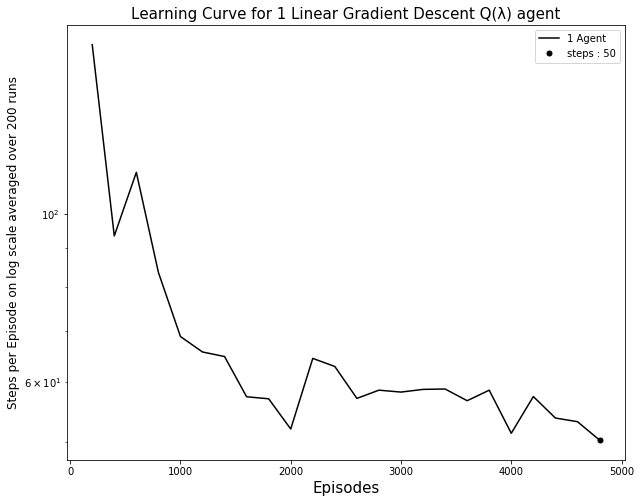

In [30]:
all_avg_steps = []
sum_steps = 0
batch =200
iteration = []

# Averaging reward over a batch of 200 episodes
for i in range(1,len(ret)):
    if i%batch == 0:
        avg_steps = sum_steps/batch
        all_avg_steps.append(avg_steps)
        iteration.append(i)
        sum_steps = 0
    else:
        sum_steps += steps[i]

# Plotting the learning curve         
plt.figure(figsize=(10,8))
plt.plot(iteration, all_avg_steps, 'k', label='1 Agent')
plt.plot(iteration[-1], all_avg_steps[-1], 'k.', markersize=10, label='steps : %.0f' %all_avg_steps[-1])
plt.yscale('log')
plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Steps per Episode on log scale averaged over 200 runs', fontsize=12)
plt.title('Learning Curve for 1 Linear Gradient Descent Q(λ) agent', fontsize=15)
plt.legend(loc='best')
plt.show()

#### 5 SARSA and 5 Q Agent GD with 5000 episodes

In [31]:
num_tiles = 9
num_tilings = 10

tile = tile_coder(num_tiles = num_tiles, num_tilings = num_tilings)
env = mountaincar.MountainCar()
episodes = 5000

agent_steps_SARSA = []
for i in range(0,5):
    agent = Linear_GD_Sarsa_Agent(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
    ret,steps = simulate_Linear_GD_Sarsa(agent, env, episodes, trace_type = 'accumulating')
    agent_steps_SARSA.append(steps)
    


In [32]:
agent_steps_Q = []
for i in range(0,5):
    agent = Linear_GD_Q_Agent(alpha = 0.1/num_tilings, greedy = 0.01, gamma = 1, lambada = 0.1)
    ret,steps = simulate_Linear_GD_Q(agent, env, episodes, trace_type = 'accumulating')
    agent_steps_Q.append(steps)

In [33]:
comb_avg_steps_SARSA = []
comb_avg_steps_Q = []
batch =500
iteration = np.linspace(0, 8, 9)*batch

# Averaging reward over a batch of 1000 episodes for 5 agents for accumulating and replacing traces
for k in range(0,5):
    all_avg_steps_SARSA = []
    all_avg_steps_Q = []
    sum_SARSA = 0
    sum_Q = 0
    for i in range(1,len(agent_steps_SARSA[k])):
        if i%batch == 0:
            avg_SARSA = sum_SARSA/batch
            avg_Q = sum_Q/batch
            
            all_avg_steps_SARSA.append(avg_SARSA)
            all_avg_steps_Q.append(avg_Q)

            sum_SARSA = 0
            sum_Q = 0
        else:
            sum_SARSA += agent_steps_SARSA[k][i]
            sum_Q += agent_steps_Q[k][i]
            
    comb_avg_steps_SARSA.append(all_avg_steps_SARSA) 
    comb_avg_steps_Q.append(all_avg_steps_Q)

    
plt.figure(figsize=(10,8))

plt.plot(iteration, np.array(comb_avg_steps_SARSA).mean(axis = 0), 'k', label='5 SARSA Agents ')
plt.plot(iteration[-1], np.array(comb_avg_steps_SARSA).mean(axis = 0)[-1], 'k.', label='Steps : %.0f' %np.array(comb_avg_steps_SARSA).mean(axis = 0)[-1], markersize=10)

plt.plot(iteration, np.array(comb_avg_steps_Q).mean(axis = 0), 'r', label='5 Q Agents ')
plt.plot(iteration[-1], np.array(comb_avg_steps_Q).mean(axis = 0)[-1], 'r.', label='Steps : %.0f' %np.array(comb_avg_steps_Q).mean(axis = 0)[-1], markersize=10)

plt.yscale('log')
plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Steps per Episode on log scale averaged over 500 runs', fontsize=12)
plt.title('Learning Curve for 5 Linear Gradient Descent SARSA and Q(λ) agents', fontsize=15)
plt.legend(loc='best')
plt.show()




__Learning Curves and Explanations__

_Comparison for α values_

<img src="LC_alpha.png" style="width: 500px;"/>

The figure above shows the LGDS learning curve with three different α values trained over 4000 episodes. The steps have been averaged over 400 runs. It shows that in the initial phase, agent with α = 0.05 (red) performs the best but around 1900th episode it is taken over by agent with α = 0.01 (blue). The agent with α = 0.02 (green) performs consistently in the middle. The agent with α = 0.01 though has a steep learning curve, performs best in the end with 56 steps on average.

_Comparison for different number of tiles_

<img src="LC_tiles.png" style="width: 500px;"/>

The figure above shows the LGDS learning curve with four different tile values trained over 4000 episodes. The steps have been averaged over 400 runs. It shows that in the initial phase, agent with tile = 5 (red) performs the best but around 2400th episode it is taken over by agent with by other agents. The agent with tile = 10 performs best with number of steps as 55 however we expect agents with tile = 15 and 20 to perform better. This could be because with increasing tile number the system becomes too complex to handle (due to exponential increase in number of parameters to learn) and it is difficult to learn the optimal policy. 

_Comparison for different number of tilings_

<img src="LC_tilings.png" style="width: 500px;"/>

The figure above shows the LGDS learning curve with four different tiling values trained over 4000 episodes. The steps have been averaged over 400 runs. It shows that in the initial phase, agent with tiling = 5 (red) and 15 (yellow) performs the better than their even counter parts 10 (blue) and 20 (green). The agent with tiling = 5 performs best with number of steps as 57. However, we expect agents with tiling = 10 or 20 to perform better. This could be because with increasing tile number the system is too complex to handle and it is difficult to learn the optimal policy. Also, it has been observe that keeping the number of tiling as odd improves final policy. 

_Comparison with Linear GD Q(λ) agent_

<img src="LC_SARSAnQ.png" style="width: 500px;"/>

The figure above shows the comparison between 5 Linear GD SARSA agents and 5 Linear GD Q agents. It is observed from the graph that performance of both algorithms under same conditions is similar however, the final policy of the Q agents is overall better than the SARSA agent. This is an expected result. Furthermore, the Q agents reach their convergence value faster. This is because Q learning is on-policy whereas SARSA is off-policy. In Q learning, we update the estimate from the maximum estimate of possible next actions, regardless of which action we took. Whilst in SARSA, we update estimates based on and take the same action. SARSA approaches convergence allowing for possible penalties from exploratory moves, whilst Q-learning ignores them, thus faster convergence.


__Rationale for approach__

The approach taken up for the comparison study is to first make minor amendments in hyperparameter α, then change the structuring of the model that is different tiltes and tilings and understand the effects based on them. Finally, we code a different algorithm (Linear GD Q(λ)) and compare the performance with our initial model. This provides us with a step-wise incremental changes and understand how changes affect the results at even the minute level.  

__Did the approach work better or worse than expected?__

Out of the four approaches we tried, two approaches showed improved performance from our initial model:
1. The number of tilings = 5 was smoother and had a better convergence outcome
2. The Linear GD Q(λ) model converged faster and provided a better final policy

__What did we learn from the experimentation?__ 

Following are some of the observation learned from the experiment:
1. Lower the α value, better the performance
2. Even numbered tile grid provide better final policies as compared to their odd numbered grid counterparts
3. Odd numbered tiling structure converges faster and smoother to better policy
4. Q(λ) agents performance is superior to SARSA
5. Generally (not always), if the start point of a learning curve is lower (lower number of step in the intial stage before learning), the agent learning is smoother, faster and reaches better final policy. 

__Other approaches that could be tried__

If time and resources would've allowed, more effort would be put into building a Deep Q-Network.
